In [ ]:
! pip install -U -q tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.3 MB/s eta 0:00:00


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/cuckoo_audio_mono'
audio = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Species:', audio)

Species: ['Guira_Cuckoo' 'Pheasant_Cuckoo' 'Indian_Cuckoo']


In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(directory=data_dir,
                                                                batch_size=64,
                                                                validation_split=0.2,
                                                               seed=0,
                                                                output_sequence_length=16000,
                                                                subset='both')

label_names = np.array(train_ds.class_names)

print()
print('label names:', label_names)

Found 300 files belonging to 3 classes.
Using 240 files for training.
Using 60 files for validation.

label names: ['Guira_Cuckoo' 'Indian_Cuckoo' 'Pheasant_Cuckoo']


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
# since the audio files have different dimensions, we need to make all of them into one dimension.

import librosa
import soundfile as sf

# Function to convert stereo audio to mono
def convert_stereo_to_mono(input_path, output_path):
    # Load stereo audio file
    stereo_audio, sr = librosa.load(input_path, sr=None, mono=False)

    # Convert to mono if stereo
    if stereo_audio.ndim > 1:
        mono_audio = librosa.to_mono(stereo_audio)
    else:
        mono_audio = stereo_audio

    # Save the mono audio file
    sf.write(output_path, mono_audio, sr)

# Specify the folder containing audio files
folder_path = '/content/drive/MyDrive/Colab Notebooks/cuckoo_audio/Indian_Cuckoo'

# Specify the folder to save mono audio files
output_folder = '/content/drive/MyDrive/Colab Notebooks/cuckoo_audio_mono/Indian_Cuckoo'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate through all audio files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.wav'):  # Adjust the file extension as needed
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, filename)

        # Convert stereo to mono and save the processed file
        convert_stereo_to_mono(input_path, output_path)

print("Conversion complete.")



Conversion complete.


In [ ]:
for ex_audio, ex_labels in train_ds.take(1):
  print(ex_audio.shape)
  print(ex_labels.shape)

(64, 16000)
(64,)


In [ ]:
label_names[[1,1,0,2]]

array(['Indian_Cuckoo', 'Indian_Cuckoo', 'Guira_Cuckoo',
       'Pheasant_Cuckoo'], dtype='<U15')

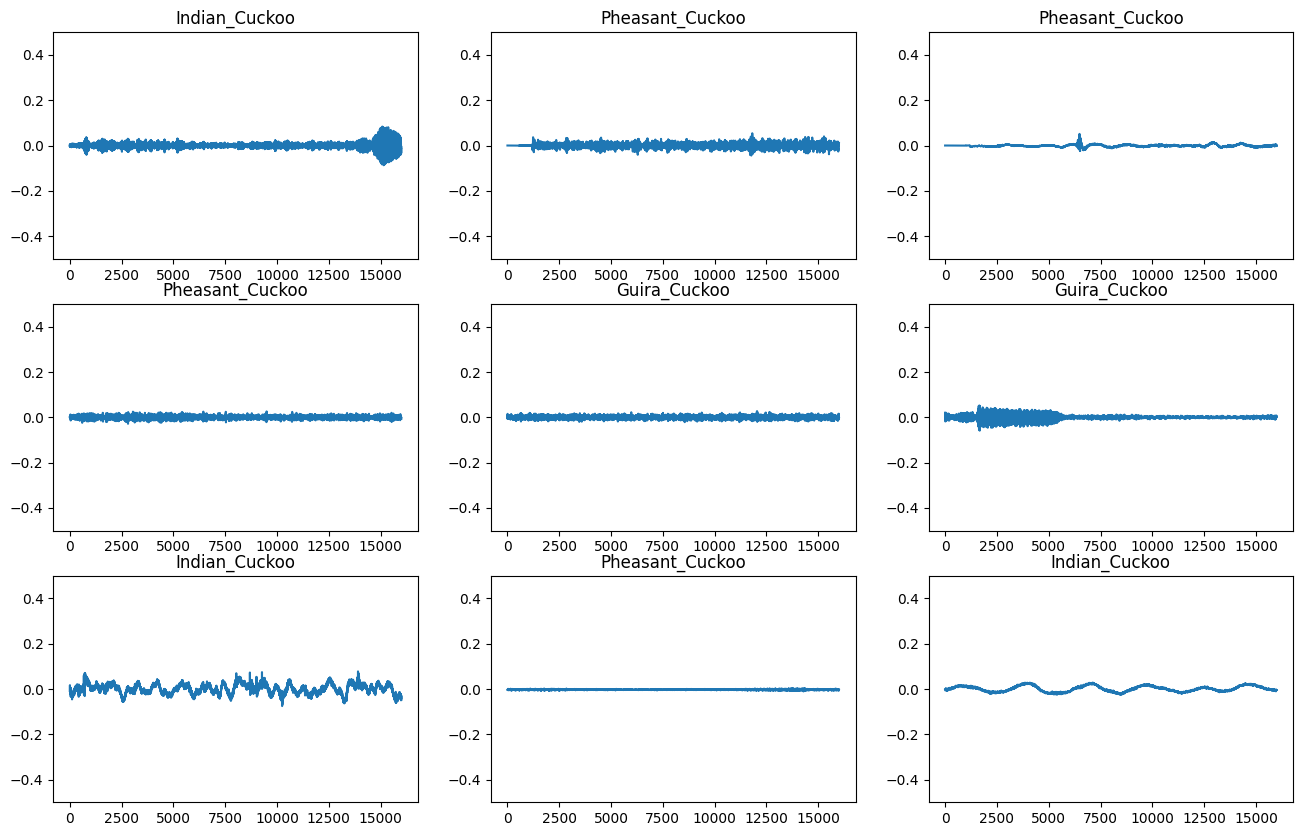

In [ ]:
plt.figure(figsize=(16,10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = ex_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[ex_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-0.5, 0.5])